In [28]:
import numpy as np
from nibabel import load
from nibabel.processing import resample_to_output
import os
from tqdm import tqdm

ROOT_DIR = '../common_data/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021'
MODEL_SHAPE = (240, 240, 155) # base brats model shape
OUTPUT_SHAPE = (256, 256, 155)

N_SAMPLES = 500
placeholder = np.zeros(shape=(N_SAMPLES, 3, *OUTPUT_SHAPE))
for idx, instance in enumerate(tqdm(os.listdir(ROOT_DIR)[: N_SAMPLES], position=0, leave=True)):
    # loading models
    mask = load(os.path.join(ROOT_DIR, instance, instance + '_seg.nii.gz'))
    flair = load(os.path.join(ROOT_DIR, instance, instance + '_flair.nii.gz'))
    t1ce = load(os.path.join(ROOT_DIR, instance, instance + '_t1ce.nii.gz'))

    # Compute the scaling factors (output will not be exactly the same as defined in OUTPUT_SHAPE)
    scale_factor = (MODEL_SHAPE[0] / OUTPUT_SHAPE[0],
                    MODEL_SHAPE[1] / OUTPUT_SHAPE[1],
                    MODEL_SHAPE[2] / OUTPUT_SHAPE[2])

    # Resample the image using trilinear interpolation
    resampled_mask = resample_to_output(mask, voxel_sizes=scale_factor, order=1).get_fdata()
    resampled_flair = resample_to_output(flair, voxel_sizes=scale_factor, order=1).get_fdata()
    resampled_t1ce = resample_to_output(t1ce, voxel_sizes=scale_factor, order=1).get_fdata()

    # Drop the last row, column, and slice to get the desired output size
    resampled_mask = resampled_mask[:OUTPUT_SHAPE[0], :OUTPUT_SHAPE[1], :OUTPUT_SHAPE[2]]
    resampled_flair = resampled_flair[:OUTPUT_SHAPE[0], :OUTPUT_SHAPE[1], :OUTPUT_SHAPE[2]]
    resampled_t1ce = resampled_t1ce[:OUTPUT_SHAPE[0], :OUTPUT_SHAPE[1], :OUTPUT_SHAPE[2]]

    # binarizing the mask (for simplicity), you can comment out this to keep all labels
    resampled_mask = (resampled_mask > 0).astype(np.float32)

    # saving models
    placeholder[idx] = np.stack([resampled_flair, resampled_t1ce, resampled_mask], axis=0)

# saving the dataset as a npy file
np.save('./data/brats_3d_dataset.npy', placeholder)

print('done!')


100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


done!


In [15]:
import torch
import matplotlib.pyplot as plt

x = torch.ones(8, 2, 128, 128)
y = torch.zeros(8, 2, 128, 128)

x = torch.vstack([img for img in x[:, 0, ...]])
# x = x.reshape(128, -1)
# y = y.reshape(128, -1)
# img = torch.cat([x, y], dim=0)

# plt.imshow(img, cmap='gray')



In [2]:
import sys
from models.gaussian_autoencoder import GaussianAutoencoder
from omegaconf import OmegaConf

CONFIG_PATH = './config/config.yaml'
if not os.path.exists(CONFIG_PATH):
    raise FileNotFoundError('Config file not found')

config = OmegaConf.load(CONFIG_PATH)

# autoencoder
autoencoder = getattr(sys.modules[__name__], config.models.autoencoder.target)

# load autoencoder weights/hyperparameters
autoencoder = autoencoder.load_from_checkpoint('./checkpoints/GaussianAutoencoder-epoch=169.ckpt')
autoencoder = autoencoder.to('cuda')

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [3]:
from models.data_module import DataModule

# data module
data_module = DataModule(
    **config.data,
    autoencoder=autoencoder,
    use_latents=True, 
    batch_size=32, 
    shuffle=True, 
    num_workers=8
)

data_module.prepare_data()
data_module.setup()
tr = data_module.train_dataloader()

Loading dataset from npy file...


100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


In [7]:
z = next(iter(tr))[0]

In [12]:
z.shape

torch.Size([32, 8, 128, 128])

In [14]:
z = z.reshape(32, 64, 2, 32, 32)

In [18]:
z.shape

torch.Size([32, 64, 2, 32, 32])

In [20]:
ex0 = z[0].to('cuda')
pemb = autoencoder.encode_position(torch.arange(0, 64, device='cuda', dtype=torch.long))
x_hat = torch.tanh(autoencoder.decode(ex0, pemb))

In [21]:
x_hat.shape

torch.Size([64, 2, 128, 128])

In [ ]:
b, pos = b.to('cuda', torch.float32), pos.to('cuda', torch.long)
x_hat, z, posterior = autoencoder(b, pos)

In [26]:
import numpy as np
n = np.arange(64)
n

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [30]:
x = torch.randn(500, 8, 128, 128)

In [41]:
x.mean()

tensor(3.0449e-05)

In [42]:
x.numel()

65536000

In [7]:
from models.vector_quantized_autoencoder import VQAutoencoder
print('Using autoencoder: ', type('fsd').__name__)

Using autoencoder:  str


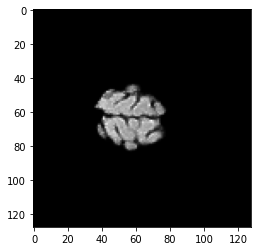

In [ ]:
plt.imshow(x_hat[0, 0, ...].detach().cpu().numpy(), cmap='gray')